# With Google Colab

In [1]:
# Google Colab 환경에서 작성
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FilePath (Google Drive)

In [2]:
%cd drive/MyDrive/인공지능응용

/content/drive/MyDrive/인공지능응용


# Import

In [3]:
import os
import pandas as pd
import numpy as np
import random as python_random

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# SEED FIX(42)

In [4]:
seed = 42
np.random.seed(seed)
python_random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Data Import

In [5]:
# Train / Test로 사전에 분리된 Data를 Import
train = pd.read_csv('/content/drive/MyDrive/인공지능응용/Dataset/train_TO.csv')
test = pd.read_csv('/content/drive/MyDrive/인공지능응용/Dataset/test_TO.csv')

# Data Preprocessing

In [6]:
# Label Encoding
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# Missing Value
train = train.fillna(0)
test = test.fillna(0)

# Only Normal Data
train_df = train[train['Y_Class']==0]

# Use Anomal, Normal Data
test_df = test.copy()

# Display
train_df

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0,0.531957,0,1,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0,0.531105,1,1,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0,0.528141,1,1,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
3,0,0.532289,1,1,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
4,0,0.531175,1,1,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000007,0.000004,0.190070,0.000031,0.000681,0.000039,0.000004,0.000003,0.188,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0,0.527129,0,1,2.0,101.0,0.0,45.0,11.0,0.0,...,0.000006,0.000004,0.190968,0.000009,0.001270,0.000022,0.000004,0.000001,0.190,0.000005
532,0,0.531375,0,0,40.0,94.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
533,0,0.529740,0,0,154.0,97.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
534,0,0.532343,1,0,146.0,94.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


# Cuda Setting

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# HyperParameter

In [8]:
Epochs = 1700
Batch_size = 32
Learning_rate = 0.1
w1 = 1
w2 = 10
w3 = 1

# DataLoader

In [9]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        self.labels = self.df['Y_Class'].values
        self.conds1 = self.df['PRODUCT_CODE'].values     # Condition 1 : PRODUCT_CODE
        self.conds2 = self.df['LINE'].values             # Condition 2 : LINE
        self.df = self.df.drop(columns=['Y_Class'])
        self.df = self.df.drop(columns=['Y_Quality'])
        self.df = self.df.drop(columns=['LINE', 'PRODUCT_CODE'])
        self.df = self.df.values

    def __getitem__(self, index):
        x = torch.Tensor(self.df[index])
        condition1 = torch.tensor(self.conds1[index], dtype=torch.long)
        condition2 = torch.tensor(self.conds2[index], dtype=torch.long)

        if self.eval_mode:
            y = torch.tensor(self.labels[index], dtype=torch.long)
            return x, y, condition1, condition2
        else:
            return x, condition1, condition2

    def __len__(self):
        return len(self.df)

In [10]:
train_dataset = MyDataset(df = train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

test_dataset = MyDataset(df = test_df, eval_mode=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

# Model : CGANomaly

In [11]:
class GANnomaly(object):

    def __init__(self):
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.discriminator = Discriminator().to(device)

        self.models = [self.encoder, self.decoder, self.discriminator]

        self.params = None
        for idx_m, model in enumerate(self.models):
            if (self.params is None):
                self.params = list(model.parameters())
            else:
                self.params = self.params + list(model.parameters())

        self.optimizer = optim.Adam(self.params, lr=Learning_rate)


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(1132, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 512),
          #nn.Linear(1132, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.LeakyReLU(),
        )

    def forward(self, x):

        z_code = self.encoder(x)

        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.condition1_size = 2         # PRODUCT_CODE를 One_Hot_Encoding (2개)
        self.condition1_layer = nn.Linear(self.condition1_size,2)
        self.condition2_size = 2         # LINE을 One_Hot_Encoding (2개)
        self.condition2_layer = nn.Linear(self.condition2_size,2)


        self.decoder = nn.Sequential(
          nn.Linear(64+4, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          # nn.Linear(512, 1132),
          nn.Linear(512, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 1132)
        )

    def forward(self, z, condition1, condition2):
        # 조건을 원-핫 인코딩으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)

        # 조건부 정보와 z를 결합
        z = torch.cat([z, condition1, condition2], 1)

        # 나머지 디코더 네트워크를 통과
        x_hat = self.decoder(z)
        return x_hat



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.condition1_size = 2  # 조건 크기
        self.condition1_layer = nn.Linear(self.condition1_size, 2)
        self.condition2_size = 2  # 조건 크기
        self.condition2_layer = nn.Linear(self.condition2_size, 2)

        self.dis_dense = nn.Sequential(
            nn.Linear(1132+4, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            # Linear(1132+5, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )


    def forward(self, x, condition1, condition2):
        # Condition을 One-Hot-Encoding으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)


        # Condition과 x를 결합
        x = torch.cat([x, condition1, condition2], 1)

        featurebank = []

        for idx, layer in enumerate(self.dis_dense):
            x = layer(x)
            if("torch.nn.modules.activation" in str(type(layer))):
                featurebank.append(x)

        disc_score = x

        return disc_score, featurebank


# Loss

In [12]:
def loss_enc(z_code, z_code_hat):

    l_enc = torch.sum((z_code - z_code_hat)**2, dim=(1)) # L2

    return l_enc

def loss_rec(x, x_hat):
    l_con = torch.sum(torch.abs(x - x_hat), dim=(1)) # L1

    return l_con

def loss_adv(dis_x, dis_x_hat, features_real, features_fake): #L2

    l_adv = torch.sum((dis_x - dis_x_hat)**2, dim=(1))


    for fidx, _ in enumerate(features_real):

        l_adv += torch.sum((features_real[fidx] - features_fake[fidx])**2, dim=(1))

    return l_adv


def loss_gan(z_code, z_code_hat, x, x_hat,
    dis_x, dis_x_hat, features_real, features_fake,
    w_enc=w1, w_con=w2, w_adv=w3):


    z_code, z_code_hat, x, x_hat = z_code, z_code_hat, x, x_hat

    for fidx, _ in enumerate(features_real):
        features_real[fidx] = features_real[fidx]
        features_fake[fidx] = features_fake[fidx]

    l_enc = loss_enc(z_code, z_code_hat)
    l_con = loss_rec(x, x_hat)
    l_adv = loss_adv(dis_x, dis_x_hat, features_real, features_fake)


    l_tot = torch.mean((w_enc * l_enc) + (w_con * l_con) + (w_adv * l_adv))

    l_enc = torch.mean(l_enc)
    l_con = torch.mean(l_con)
    l_adv = torch.mean(l_adv)


    return l_tot, l_enc, l_con, l_adv

# Model_Fit

In [13]:
epochs = Epochs

model = GANnomaly()
model.decoder.train()
model.discriminator.train()

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []
disc_loss_per_epoch = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.3, patience=20, threshold_mode='abs', min_lr=1e-8, verbose=True)


for i in range(1,epochs+1) :

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    disc_loss = []
    best_score = 0

    for idx, (data, condition1, condition2) in enumerate(train_loader):

        x = data.to(device)
        # Condition
        condition1 = condition1.to(device)
        condition2 = condition2.to(device)

        z_code = model.encoder(x)
        x_hat = model.decoder(z_code, condition1, condition2)
        z_code_hat = model.encoder(x_hat)

        dis_x, features_real = model.discriminator(x, condition1, condition2)
        dis_x_hat, features_fake = model.discriminator(x_hat, condition1, condition2)


        l_tot, l_enc, l_con, l_adv = loss_gan(z_code, z_code_hat,
                                       x, x_hat,
                                       dis_x, dis_x_hat,
                                       features_real, features_fake)

        model.optimizer.zero_grad()
        l_tot.backward()
        model.optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())
        disc_loss.append(l_adv.item())


    encoder_loss_per_epoch.append(np.mean(encoder_loss))
    decoder_loss_per_epoch.append(np.mean(decoder_loss))
    disc_loss_per_epoch.append(np.mean(disc_loss))
    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}] Disc loss : [{np.mean(disc_loss)}] )')


    score = np.mean(train_loss)
    scheduler.step(np.mean(train_loss))

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_1).pth', _use_new_zipfile_serialization=False)
        torch.save(model.decoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_1).pth', _use_new_zipfile_serialization=False)

Epoch : [1] Train loss : [1911133.9632352942] Encoder loss : [26.750529948402853] Decoder loss : [191087.15533088235] Disc loss : [235.674404705272] )
Epoch : [2] Train loss : [1657780.6617647058] Encoder loss : [16.1037574375377] Decoder loss : [165776.3768382353] Disc loss : [0.7246929126627305] )
Epoch : [3] Train loss : [1617014.5294117648] Encoder loss : [7.754131040152381] Decoder loss : [161700.5955882353] Disc loss : [0.8297737977083992] )
Epoch : [4] Train loss : [1508583.5220588236] Encoder loss : [2.333793482359718] Decoder loss : [150858.078125] Disc loss : [0.4064711568986668] )
Epoch : [5] Train loss : [1451340.4705882352] Encoder loss : [0.762694842675153] Decoder loss : [145133.95036764705] Disc loss : [0.17921016803559134] )
Epoch : [6] Train loss : [1370824.3676470588] Encoder loss : [0.6800638612578896] Decoder loss : [137082.35615808822] Disc loss : [0.146169637055958] )
Epoch : [7] Train loss : [1269559.4779411764] Encoder loss : [0.6930219171678319] Decoder loss :

# Loss Visualization

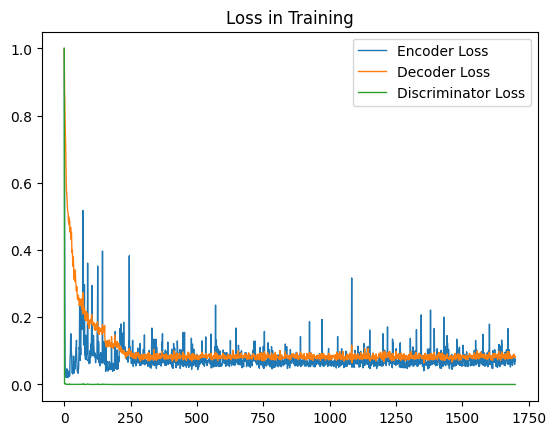

In [14]:
#visualize results

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]
vis_disc_loss = [x / max(disc_loss_per_epoch) for x in disc_loss_per_epoch]


plt.plot(vis_encoder_loss,label='Encoder Loss',linewidth=1.)
plt.plot(vis_decoder_loss,label='Decoder Loss',linewidth=1.)
plt.plot(vis_disc_loss,label='Discriminator Loss',linewidth=1.)

plt.title('Loss in Training')
plt.legend()
plt.show()

#Model_Load

In [15]:
model = GANnomaly()
model.encoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_1).pth'))
model.decoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_1).pth'))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (condition1_layer): Linear(in_features=2, out_features=2, bias=True)
  (condition2_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1024, out_features=1132,

# Model_Eval

In [16]:
def calculate_anomaly_score(x, x_hat):
    return torch.sum(torch.abs(x - x_hat), dim=1)

def feature_scale(anomaly_scores):
    min_score = np.min(anomaly_scores)
    max_score = np.max(anomaly_scores)
    return (anomaly_scores - min_score) / (max_score - min_score)

In [17]:
model.encoder.eval()
model.decoder.eval()
val_anomaly_scores = []

with torch.no_grad():
    for data, label, conds1, conds2  in test_loader:
        data = data.to(device)
        label = label.to(device)
        conds1 = conds1.to(device)
        conds2 = conds2.to(device)

        # 인코더와 디코더를 통한 데이터의 재구성
        reconstructed_data = model.decoder(model.encoder(data), conds1, conds2)

        # 이상치 점수 계산
        anomaly_score = calculate_anomaly_score(data, reconstructed_data) # Reconstructed_Error : Anomaly Score
        val_anomaly_scores.extend(anomaly_score.cpu().numpy())

scaled_anomaly_scores = feature_scale(np.array(val_anomaly_scores))

# Anomaly Classification With Threshold

In [18]:
thr = 0.5
pred_GAN = np.where(scaled_anomaly_scores > thr,1,0) # Threshold보다 높은 Anomaly Score를 나타내면 이상치(1)로 분류

# Result

In [19]:
# Confusion Matrix
print(confusion_matrix(test_df['Y_Class'],pred_GAN))

# Clssificaion Report
print(classification_report(test_df['Y_Class'],pred_GAN))

[[89 11]
 [73 27]]
              precision    recall  f1-score   support

           0       0.55      0.89      0.68       100
           1       0.71      0.27      0.39       100

    accuracy                           0.58       200
   macro avg       0.63      0.58      0.54       200
weighted avg       0.63      0.58      0.54       200



# Visualization

## Threshold

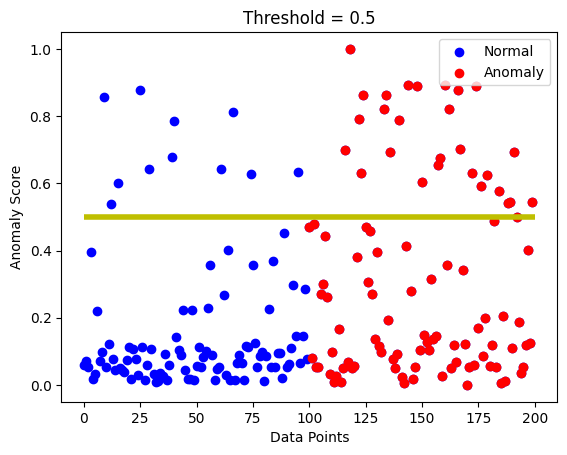

In [20]:
# Visualization

plt.scatter(range(len(scaled_anomaly_scores)), scaled_anomaly_scores, c='b', label='Normal')
plt.scatter(np.array(range(len(scaled_anomaly_scores)))[test_df['Y_Class'] == 1], scaled_anomaly_scores[test_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(thr, xmin=0, xmax=len(scaled_anomaly_scores), colors='y', linewidth=4)

plt.title(f'Threshold = {thr}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

## Confusion Matrix

accuracy:  0.58
recall:  0.27
precision:  0.711
f1-score:  0.391


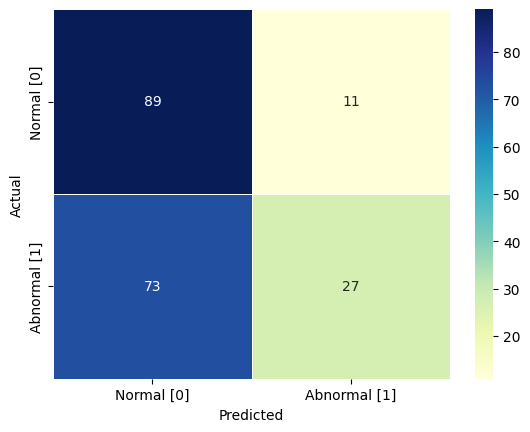

In [21]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN),3))

#Anomaly Classification With Kmeans

## Kmeans Visualization

In [22]:
from sklearn.cluster import KMeans

def visualize_kmeans_result(model, data, data_label, name, cluster_colors):
    # 모델 clustering 예측 결과와 실제 label 데이터를 가시화할 2개의 subplot
    n_cols = 2
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 클러스터링 모델로 클러스터링 결과를 저장
    cluster_labels = model.fit_predict(data.reshape(-1, 1)) # 1차원 데이터를 2차원으로 변환

    # 두 군집 중 평균이 더 높은 군집을 찾아 이진 분류 수행
    pred_GAN_K = [1 if cluster_labels[i] == 0 else 0 for i in range(len(cluster_labels))]

    # 데이터프레임 생성
    dataframe = pd.DataFrame({
        'Index': np.arange(len(data)),
        'Value': data,
        'Cluster': pred_GAN_K
    })

    unique_labels = np.unique(pred_GAN_K)

    # 클러스터링 결과값 별로 scatter plot 으로 시각화
    for label in unique_labels:
        label_df = dataframe[dataframe['Cluster'] == label]
        axs[0].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label='Cluster ' + str(label), color=cluster_colors[label])
    axs[0].set_title(name + ' Cluster Visualization')
    axs[0].legend()

    # 레이블 정보별로 scatter plot을 시각화
    unique_labels = np.unique(data_label)
    label_colors = ['tab:blue', 'tab:green', 'tab:orange']
    for label in unique_labels:
        label_df = dataframe[data_label == label]
        axs[1].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label=str(label), color=label_colors[label])
    axs[1].set_title(name + ' Label Visualization')
    axs[1].legend()

    plt.show()
    return pred_GAN_K


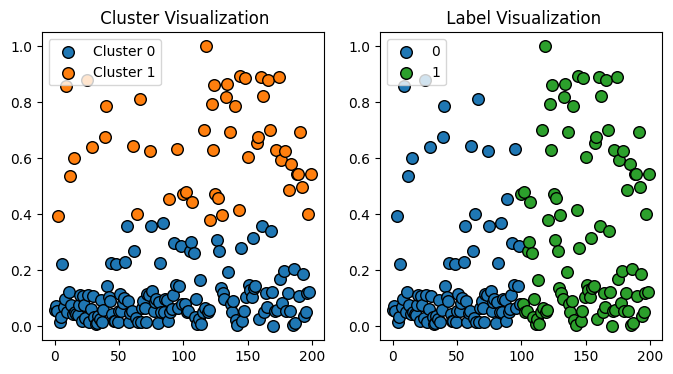

In [23]:
# Classification
cluster_color = ['tab:blue', 'tab:orange']
tuned_model = KMeans(n_clusters=2, init='k-means++', max_iter=100000, n_init=100, random_state=42)
pred_GAN_K = visualize_kmeans_result(tuned_model, scaled_anomaly_scores,test_df['Y_Class'] , '', cluster_color)

## Kmeans Confusion Mat

accuracy:  0.62
recall:  0.38
precision:  0.731
f1-score:  0.5


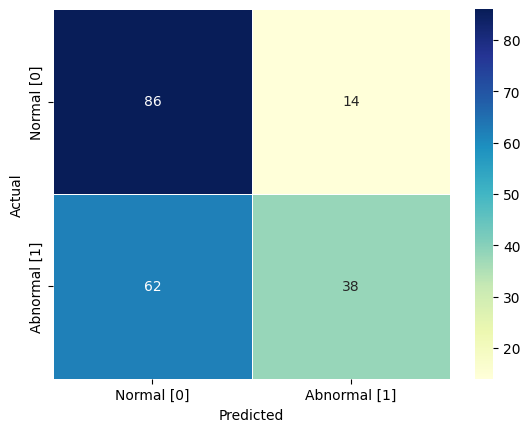

In [24]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN_K)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN_K))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN_K),3))



---


# PART2

In [25]:
Epochs = 1700
Batch_size = 32
Learning_rate = 0.01
w1 = 1
w2 = 10
w3 = 1

In [26]:
class GANnomaly(object):

    def __init__(self):
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.discriminator = Discriminator().to(device)

        self.models = [self.encoder, self.decoder, self.discriminator]

        self.params = None
        for idx_m, model in enumerate(self.models):
            if (self.params is None):
                self.params = list(model.parameters())
            else:
                self.params = self.params + list(model.parameters())

        self.optimizer = optim.Adam(self.params, lr=Learning_rate)


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(1132, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 512),
          #nn.Linear(1132, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.LeakyReLU(),
        )

    def forward(self, x):

        z_code = self.encoder(x)

        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.condition1_size = 2         # PRODUCT_CODE를 One_Hot_Encoding (2개)
        self.condition1_layer = nn.Linear(self.condition1_size,2)
        self.condition2_size = 2         # LINE을 One_Hot_Encoding (2개)
        self.condition2_layer = nn.Linear(self.condition2_size,2)


        self.decoder = nn.Sequential(
          nn.Linear(64+4, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          # nn.Linear(512, 1132),
          nn.Linear(512, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 1132)
        )

    def forward(self, z, condition1, condition2):
        # 조건을 원-핫 인코딩으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)

        # 조건부 정보와 z를 결합
        z = torch.cat([z, condition1, condition2], 1)

        # 나머지 디코더 네트워크를 통과
        x_hat = self.decoder(z)
        return x_hat



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.condition1_size = 2  # 조건 크기
        self.condition1_layer = nn.Linear(self.condition1_size, 2)
        self.condition2_size = 2  # 조건 크기
        self.condition2_layer = nn.Linear(self.condition2_size, 2)

        self.dis_dense = nn.Sequential(
            nn.Linear(1132+4, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            # Linear(1132+5, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )


    def forward(self, x, condition1, condition2):
        # Condition을 One-Hot-Encoding으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)


        # Condition과 x를 결합
        x = torch.cat([x, condition1, condition2], 1)

        featurebank = []

        for idx, layer in enumerate(self.dis_dense):
            x = layer(x)
            if("torch.nn.modules.activation" in str(type(layer))):
                featurebank.append(x)

        disc_score = x

        return disc_score, featurebank


In [27]:
epochs = Epochs

model = GANnomaly()
model.decoder.train()
model.discriminator.train()

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []
disc_loss_per_epoch = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.3, patience=20, threshold_mode='abs', min_lr=1e-8, verbose=True)


for i in range(1,epochs+1) :

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    disc_loss = []
    best_score = 0

    for idx, (data, condition1, condition2) in enumerate(train_loader):

        x = data.to(device)
        # Condition
        condition1 = condition1.to(device)
        condition2 = condition2.to(device)

        z_code = model.encoder(x)
        x_hat = model.decoder(z_code, condition1, condition2)
        z_code_hat = model.encoder(x_hat)

        dis_x, features_real = model.discriminator(x, condition1, condition2)
        dis_x_hat, features_fake = model.discriminator(x_hat, condition1, condition2)


        l_tot, l_enc, l_con, l_adv = loss_gan(z_code, z_code_hat,
                                       x, x_hat,
                                       dis_x, dis_x_hat,
                                       features_real, features_fake)

        model.optimizer.zero_grad()
        l_tot.backward()
        model.optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())
        disc_loss.append(l_adv.item())


    encoder_loss_per_epoch.append(np.mean(encoder_loss))
    decoder_loss_per_epoch.append(np.mean(decoder_loss))
    disc_loss_per_epoch.append(np.mean(disc_loss))
    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}] Disc loss : [{np.mean(disc_loss)}] )')


    score = np.mean(train_loss)
    scheduler.step(np.mean(train_loss))

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_01).pth', _use_new_zipfile_serialization=False)
        torch.save(model.decoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_01).pth', _use_new_zipfile_serialization=False)

Epoch : [1] Train loss : [1956942.9705882352] Encoder loss : [19.765971155727613] Decoder loss : [195640.06985294117] Disc loss : [522.5275636560776] )
Epoch : [2] Train loss : [1782410.5294117648] Encoder loss : [8.404980491189395] Decoder loss : [178230.40625] Disc loss : [98.04656443876378] )
Epoch : [3] Train loss : [1671876.8823529412] Encoder loss : [6.718026764252606] Decoder loss : [167182.4806985294] Disc loss : [45.32897186279297] )
Epoch : [4] Train loss : [1612922.0294117648] Encoder loss : [1.8110721637220943] Decoder loss : [161289.75091911765] Disc loss : [22.703278485466452] )
Epoch : [5] Train loss : [1599452.2426470588] Encoder loss : [1.3909901424365885] Decoder loss : [159941.71645220587] Disc loss : [33.69873018825756] )
Epoch : [6] Train loss : [1570379.8088235294] Encoder loss : [1.59539596824085] Decoder loss : [157036.0528492647] Disc loss : [17.674799049601834] )
Epoch : [7] Train loss : [1515538.1911764706] Encoder loss : [0.65007583008093] Decoder loss : [15

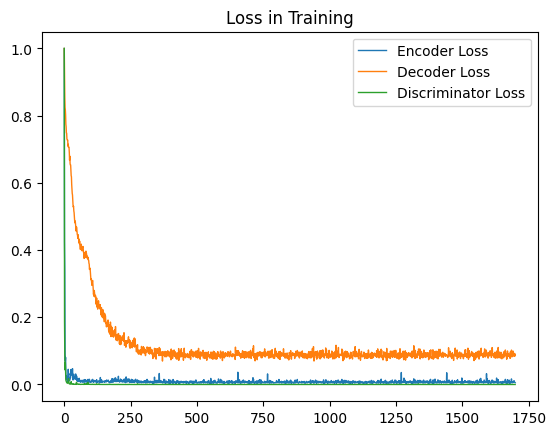

In [28]:
#visualize results

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]
vis_disc_loss = [x / max(disc_loss_per_epoch) for x in disc_loss_per_epoch]


plt.plot(vis_encoder_loss,label='Encoder Loss',linewidth=1.)
plt.plot(vis_decoder_loss,label='Decoder Loss',linewidth=1.)
plt.plot(vis_disc_loss,label='Discriminator Loss',linewidth=1.)

plt.title('Loss in Training')
plt.legend()
plt.show()

In [29]:
model = GANnomaly()
model.encoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_01).pth'))
model.decoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_01).pth'))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (condition1_layer): Linear(in_features=2, out_features=2, bias=True)
  (condition2_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1024, out_features=1132,

In [30]:
model.encoder.eval()
model.decoder.eval()
val_anomaly_scores = []

with torch.no_grad():
    for data, label, conds1, conds2  in test_loader:
        data = data.to(device)
        label = label.to(device)
        conds1 = conds1.to(device)
        conds2 = conds2.to(device)

        # 인코더와 디코더를 통한 데이터의 재구성
        reconstructed_data = model.decoder(model.encoder(data), conds1, conds2)

        # 이상치 점수 계산
        anomaly_score = calculate_anomaly_score(data, reconstructed_data) # Reconstructed_Error : Anomaly Score
        val_anomaly_scores.extend(anomaly_score.cpu().numpy())

scaled_anomaly_scores = feature_scale(np.array(val_anomaly_scores))

In [31]:
thr = 0.5
pred_GAN = np.where(scaled_anomaly_scores > thr,1,0) # Threshold보다 높은 Anomaly Score를 나타내면 이상치(1)로 분류

In [32]:
# Confusion Matrix
print(confusion_matrix(test_df['Y_Class'],pred_GAN))

# Clssificaion Report
print(classification_report(test_df['Y_Class'],pred_GAN))

[[91  9]
 [68 32]]
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       100
           1       0.78      0.32      0.45       100

    accuracy                           0.61       200
   macro avg       0.68      0.61      0.58       200
weighted avg       0.68      0.61      0.58       200



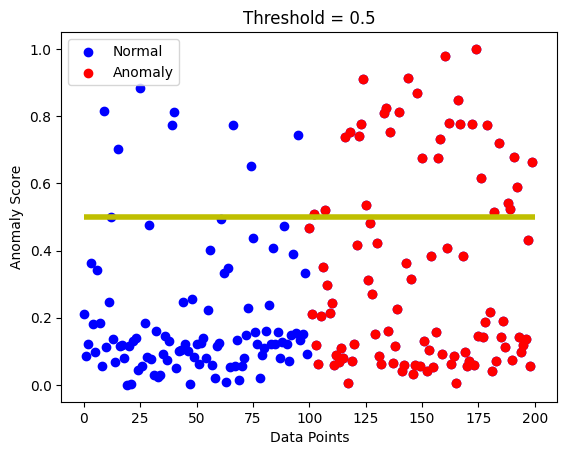

In [33]:
# Visualization

plt.scatter(range(len(scaled_anomaly_scores)), scaled_anomaly_scores, c='b', label='Normal')
plt.scatter(np.array(range(len(scaled_anomaly_scores)))[test_df['Y_Class'] == 1], scaled_anomaly_scores[test_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(thr, xmin=0, xmax=len(scaled_anomaly_scores), colors='y', linewidth=4)

plt.title(f'Threshold = {thr}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

accuracy:  0.615
recall:  0.32
precision:  0.78
f1-score:  0.454


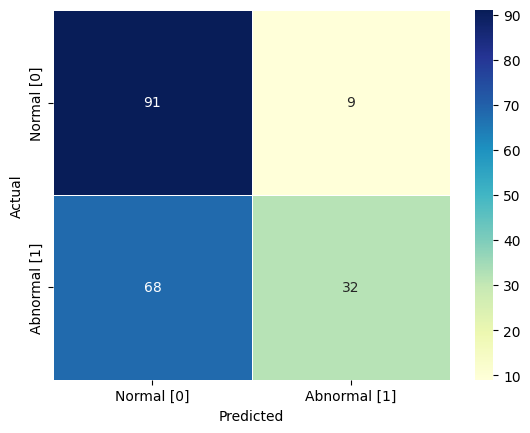

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN),3))

In [35]:
from sklearn.cluster import KMeans

def visualize_kmeans_result(model, data, data_label, name, cluster_colors):
    # 모델 clustering 예측 결과와 실제 label 데이터를 가시화할 2개의 subplot
    n_cols = 2
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 클러스터링 모델로 클러스터링 결과를 저장
    cluster_labels = model.fit_predict(data.reshape(-1, 1)) # 1차원 데이터를 2차원으로 변환

    # 두 군집 중 평균이 더 높은 군집을 찾아 이진 분류 수행
    pred_GAN_K = [1 if cluster_labels[i] == 0 else 0 for i in range(len(cluster_labels))]

    # 데이터프레임 생성
    dataframe = pd.DataFrame({
        'Index': np.arange(len(data)),
        'Value': data,
        'Cluster': pred_GAN_K
    })

    unique_labels = np.unique(pred_GAN_K)

    # 클러스터링 결과값 별로 scatter plot 으로 시각화
    for label in unique_labels:
        label_df = dataframe[dataframe['Cluster'] == label]
        axs[0].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label='Cluster ' + str(label), color=cluster_colors[label])
    axs[0].set_title(name + ' Cluster Visualization')
    axs[0].legend()

    # 레이블 정보별로 scatter plot을 시각화
    unique_labels = np.unique(data_label)
    label_colors = ['tab:blue', 'tab:green', 'tab:orange']
    for label in unique_labels:
        label_df = dataframe[data_label == label]
        axs[1].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label=str(label), color=label_colors[label])
    axs[1].set_title(name + ' Label Visualization')
    axs[1].legend()

    plt.show()
    return pred_GAN_K


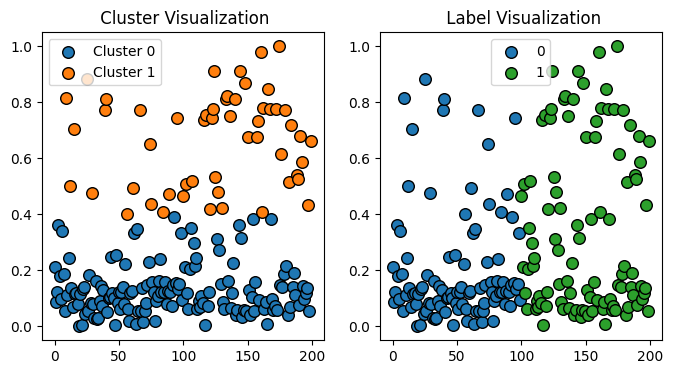

In [36]:
# Classification
cluster_color = ['tab:blue', 'tab:orange']
tuned_model = KMeans(n_clusters=2, init='k-means++', max_iter=100000, n_init=100, random_state=42)
pred_GAN_K = visualize_kmeans_result(tuned_model, scaled_anomaly_scores,test_df['Y_Class'] , '', cluster_color)

accuracy:  0.615
recall:  0.38
precision:  0.717
f1-score:  0.497


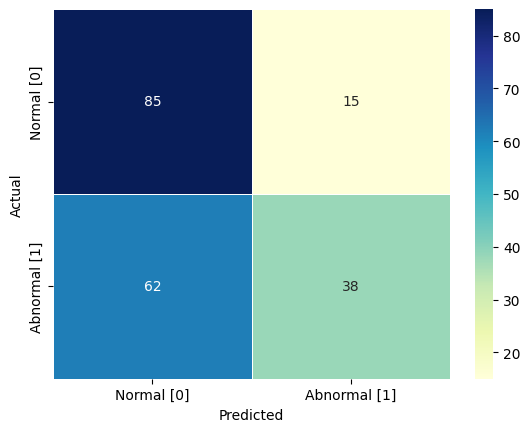

In [37]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN_K)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN_K))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN_K),3))



---


#PART3

In [38]:
Epochs = 1700
Batch_size = 32
Learning_rate = 0.001
w1 = 1
w2 = 10
w3 = 1

In [39]:
class GANnomaly(object):

    def __init__(self):
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.discriminator = Discriminator().to(device)

        self.models = [self.encoder, self.decoder, self.discriminator]

        self.params = None
        for idx_m, model in enumerate(self.models):
            if (self.params is None):
                self.params = list(model.parameters())
            else:
                self.params = self.params + list(model.parameters())

        self.optimizer = optim.Adam(self.params, lr=Learning_rate)


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(1132, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 512),
          #nn.Linear(1132, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.LeakyReLU(),
        )

    def forward(self, x):

        z_code = self.encoder(x)

        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.condition1_size = 2         # PRODUCT_CODE를 One_Hot_Encoding (2개)
        self.condition1_layer = nn.Linear(self.condition1_size,2)
        self.condition2_size = 2         # LINE을 One_Hot_Encoding (2개)
        self.condition2_layer = nn.Linear(self.condition2_size,2)


        self.decoder = nn.Sequential(
          nn.Linear(64+4, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          # nn.Linear(512, 1132),
          nn.Linear(512, 1024),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 1132)
        )

    def forward(self, z, condition1, condition2):
        # 조건을 원-핫 인코딩으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)

        # 조건부 정보와 z를 결합
        z = torch.cat([z, condition1, condition2], 1)

        # 나머지 디코더 네트워크를 통과
        x_hat = self.decoder(z)
        return x_hat



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.condition1_size = 2  # 조건 크기
        self.condition1_layer = nn.Linear(self.condition1_size, 2)
        self.condition2_size = 2  # 조건 크기
        self.condition2_layer = nn.Linear(self.condition2_size, 2)

        self.dis_dense = nn.Sequential(
            nn.Linear(1132+4, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            # Linear(1132+5, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )


    def forward(self, x, condition1, condition2):
        # Condition을 One-Hot-Encoding으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)


        # Condition과 x를 결합
        x = torch.cat([x, condition1, condition2], 1)

        featurebank = []

        for idx, layer in enumerate(self.dis_dense):
            x = layer(x)
            if("torch.nn.modules.activation" in str(type(layer))):
                featurebank.append(x)

        disc_score = x

        return disc_score, featurebank


In [40]:
epochs = Epochs

model = GANnomaly()
model.decoder.train()
model.discriminator.train()

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []
disc_loss_per_epoch = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.3, patience=20, threshold_mode='abs', min_lr=1e-8, verbose=True)


for i in range(1,epochs+1) :

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    disc_loss = []
    best_score = 0

    for idx, (data, condition1, condition2) in enumerate(train_loader):

        x = data.to(device)
        # Condition
        condition1 = condition1.to(device)
        condition2 = condition2.to(device)

        z_code = model.encoder(x)
        x_hat = model.decoder(z_code, condition1, condition2)
        z_code_hat = model.encoder(x_hat)

        dis_x, features_real = model.discriminator(x, condition1, condition2)
        dis_x_hat, features_fake = model.discriminator(x_hat, condition1, condition2)


        l_tot, l_enc, l_con, l_adv = loss_gan(z_code, z_code_hat,
                                       x, x_hat,
                                       dis_x, dis_x_hat,
                                       features_real, features_fake)

        model.optimizer.zero_grad()
        l_tot.backward()
        model.optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())
        disc_loss.append(l_adv.item())


    encoder_loss_per_epoch.append(np.mean(encoder_loss))
    decoder_loss_per_epoch.append(np.mean(decoder_loss))
    disc_loss_per_epoch.append(np.mean(disc_loss))
    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}] Disc loss : [{np.mean(disc_loss)}] )')


    score = np.mean(train_loss)
    scheduler.step(np.mean(train_loss))

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_001).pth', _use_new_zipfile_serialization=False)
        torch.save(model.decoder.state_dict(), '/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_001).pth', _use_new_zipfile_serialization=False)

Epoch : [1] Train loss : [2043034.0882352942] Encoder loss : [22.39953046686509] Decoder loss : [204251.49724264705] Disc loss : [496.70542638442095] )
Epoch : [2] Train loss : [2010321.1985294118] Encoder loss : [15.248528368332806] Decoder loss : [201012.1075367647] Disc loss : [184.87210442038145] )
Epoch : [3] Train loss : [1979675.4852941176] Encoder loss : [13.451396942138672] Decoder loss : [197955.0330882353] Disc loss : [111.69311792710248] )
Epoch : [4] Train loss : [1946049.044117647] Encoder loss : [11.88418326658361] Decoder loss : [194597.33547794117] Disc loss : [63.79359480913948] )
Epoch : [5] Train loss : [1917388.9926470588] Encoder loss : [8.639140690074248] Decoder loss : [191734.27573529413] Disc loss : [37.545428668751434] )
Epoch : [6] Train loss : [1882272.6102941176] Encoder loss : [7.691838488859289] Decoder loss : [188224.1231617647] Disc loss : [23.657538582296933] )
Epoch : [7] Train loss : [1860523.6911764706] Encoder loss : [7.269182317397174] Decoder lo

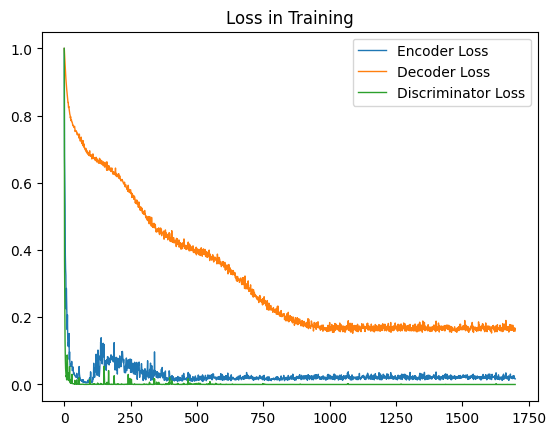

In [41]:
#visualize results

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]
vis_disc_loss = [x / max(disc_loss_per_epoch) for x in disc_loss_per_epoch]


plt.plot(vis_encoder_loss,label='Encoder Loss',linewidth=1.)
plt.plot(vis_decoder_loss,label='Decoder Loss',linewidth=1.)
plt.plot(vis_disc_loss,label='Discriminator Loss',linewidth=1.)

plt.title('Loss in Training')
plt.legend()
plt.show()

In [42]:
model = GANnomaly()
model.encoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_encoder_(0_001).pth'))
model.decoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/CGAN_Models/best_CGAN_decoder_(0_001).pth'))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (condition1_layer): Linear(in_features=2, out_features=2, bias=True)
  (condition2_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1024, out_features=1132,

In [43]:
model.encoder.eval()
model.decoder.eval()
val_anomaly_scores = []

with torch.no_grad():
    for data, label, conds1, conds2  in test_loader:
        data = data.to(device)
        label = label.to(device)
        conds1 = conds1.to(device)
        conds2 = conds2.to(device)

        # 인코더와 디코더를 통한 데이터의 재구성
        reconstructed_data = model.decoder(model.encoder(data), conds1, conds2)

        # 이상치 점수 계산
        anomaly_score = calculate_anomaly_score(data, reconstructed_data) # Reconstructed_Error : Anomaly Score
        val_anomaly_scores.extend(anomaly_score.cpu().numpy())

scaled_anomaly_scores = feature_scale(np.array(val_anomaly_scores))

In [44]:
thr = 0.5
pred_GAN = np.where(scaled_anomaly_scores > thr,1,0) # Threshold보다 높은 Anomaly Score를 나타내면 이상치(1)로 분류

In [45]:
# Confusion Matrix
print(confusion_matrix(test_df['Y_Class'],pred_GAN))

# Clssificaion Report
print(classification_report(test_df['Y_Class'],pred_GAN))

[[94  6]
 [80 20]]
              precision    recall  f1-score   support

           0       0.54      0.94      0.69       100
           1       0.77      0.20      0.32       100

    accuracy                           0.57       200
   macro avg       0.65      0.57      0.50       200
weighted avg       0.65      0.57      0.50       200



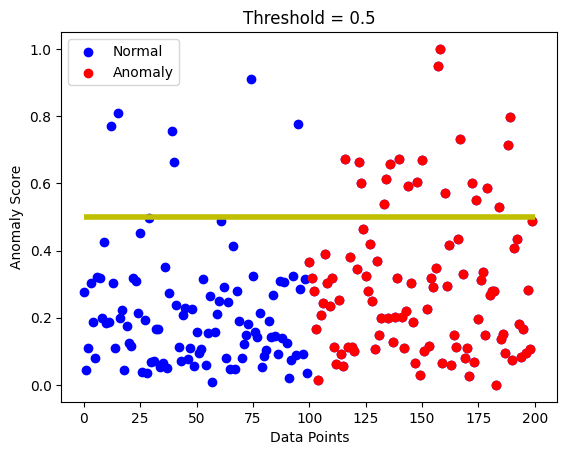

In [46]:
# Visualization

plt.scatter(range(len(scaled_anomaly_scores)), scaled_anomaly_scores, c='b', label='Normal')
plt.scatter(np.array(range(len(scaled_anomaly_scores)))[test_df['Y_Class'] == 1], scaled_anomaly_scores[test_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(thr, xmin=0, xmax=len(scaled_anomaly_scores), colors='y', linewidth=4)

plt.title(f'Threshold = {thr}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

accuracy:  0.57
recall:  0.2
precision:  0.769
f1-score:  0.317


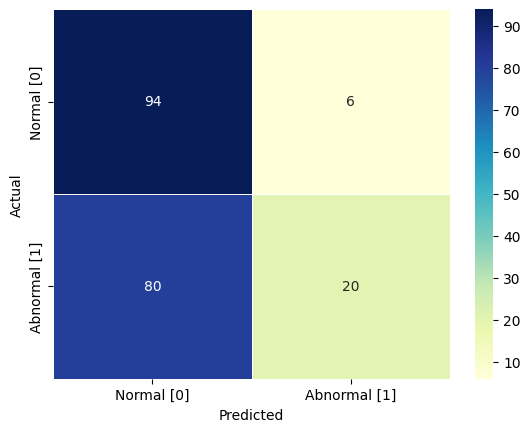

In [47]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN),3))

In [48]:
from sklearn.cluster import KMeans

def visualize_kmeans_result(model, data, data_label, name, cluster_colors):
    # 모델 clustering 예측 결과와 실제 label 데이터를 가시화할 2개의 subplot
    n_cols = 2
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 클러스터링 모델로 클러스터링 결과를 저장
    cluster_labels = model.fit_predict(data.reshape(-1, 1)) # 1차원 데이터를 2차원으로 변환

    # 두 군집 중 평균이 더 높은 군집을 찾아 이진 분류 수행
    pred_GAN_K = [1 if cluster_labels[i] == 0 else 0 for i in range(len(cluster_labels))]

    # 데이터프레임 생성
    dataframe = pd.DataFrame({
        'Index': np.arange(len(data)),
        'Value': data,
        'Cluster': pred_GAN_K
    })

    unique_labels = np.unique(pred_GAN_K)

    # 클러스터링 결과값 별로 scatter plot 으로 시각화
    for label in unique_labels:
        label_df = dataframe[dataframe['Cluster'] == label]
        axs[0].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label='Cluster ' + str(label), color=cluster_colors[label])
    axs[0].set_title(name + ' Cluster Visualization')
    axs[0].legend()

    # 레이블 정보별로 scatter plot을 시각화
    unique_labels = np.unique(data_label)
    label_colors = ['tab:blue', 'tab:green', 'tab:orange']
    for label in unique_labels:
        label_df = dataframe[data_label == label]
        axs[1].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label=str(label), color=label_colors[label])
    axs[1].set_title(name + ' Label Visualization')
    axs[1].legend()

    plt.show()
    return pred_GAN_K


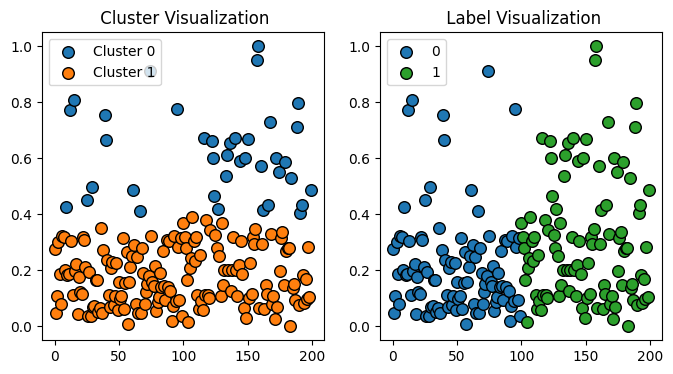

In [49]:
# Classification
cluster_color = ['tab:blue', 'tab:orange']
tuned_model = KMeans(n_clusters=2, init='k-means++', max_iter=100000, n_init=100, random_state=42)
pred_GAN_K = visualize_kmeans_result(tuned_model, scaled_anomaly_scores,test_df['Y_Class'] , '', cluster_color)

accuracy:  0.42
recall:  0.73
precision:  0.451
f1-score:  0.557


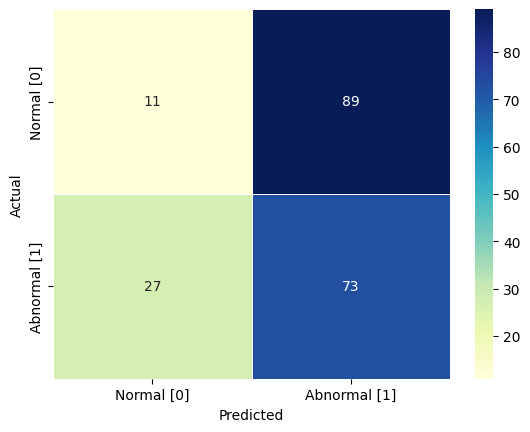

In [50]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN_K)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN_K))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN_K),3))